# Chapter 8: Recommender Systems.

In this notebook we will see how to create a recommender system. To
this end we will explore different properties of recommender systems, develope and evaluate a collaborative recommender system.



In [1]:
import matplotlib.pylab as plt

%matplotlib inline 
plt.style.use('seaborn-whitegrid')
plt.rc('text', usetex=True)
plt.rc('font', family='times')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.rc('font', size=12) 

## Data description

We will work with the well known MovieLens dataset (http://grouplens.org/datasets/movielens/). This dataset was initially constructed to support participants in the Netflix Prize. Today, we can find several versions of this dataset with different amout of data, from 100k samples version to 20m sample version.
Although performance on bigger dataset is expected to be better, we will work with the smallest dataset: MovieLens *100K Dataset (ml-100k-zip)*. Working with this lite version has the benefit of less computational costs, while we will also get the skills required on user-based recommender systems.

With a unix machine the dataset can be downloaded with the following code:

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip 
!unzip ml-100k.zip -d "files/ch09/"

zsh:1: command not found: wget
unzip:  cannot find or open ml-100k.zip, ml-100k.zip.zip or ml-100k.zip.ZIP.


If you are working with a windows machine, please go to the website and download the 100k version and extract it to the subdirectory named "files/ch8/ml-100k/"

Once you have downloaded and unzipped the file into a directory, you can create a DataFrame with the following code:

In [3]:
#NETFLIX REAL 50.000.000 usuaris and 100.000 items
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
from math import isnan
from tqdm import tqdm # conda install -y tqdm


# Load Data set
u_cols = [
    'user_id', 'age', 'sex', 
    'occupation', 'zip_code']

users = pd.read_csv('files/ch09/ml-100k/u.user', 
                    sep='|', 
                    names=u_cols)

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('files/ch09/ml-100k/u.data', sep='\t', names=r_cols)

# We will only load the first three columns of the filewith usecols
m_cols = ['movie_id', 'title', 'release_date']
movies = pd.read_csv('files/ch09/ml-100k/u.item', sep='|', names=m_cols, usecols=range(3), encoding='latin-1')

# Construcció del DataFrame
data = pd.merge(pd.merge(ratings, users), movies)
data = data[['user_id','title', 'movie_id','rating']]

print("The database has "+ str(data.shape[0]) +" observed ratings")
print("The database has ", data.user_id.nunique()," users")
print("The database has ", data.movie_id.nunique(), " movies")
print(data.head())

The database has 100000 observed ratings
The database has  943  users
The database has  1682  movies
   user_id         title  movie_id  rating
0      196  Kolya (1996)       242       3
1      305  Kolya (1996)       242       5
2        6  Kolya (1996)       242       4
3      234  Kolya (1996)       242       4
4       63  Kolya (1996)       242       3


If you explore the dataset in detail, you will see that it  consists of:
<ul>
<li>1,000,209 ratings from 6040 users of 3706 movies. Ratings are from 1 to 5.</li>
<li>Each user has rated at least 20 movies.</li>
<li>Simple demographic info for the users (age, gender, occupation, zip)</li>
</ul>

## Building a Collaborative Filtering (CF) for Movilens dataset
The idea behind any recommender system is to suggest or recommend items that are likely to be of interest to the user. If we think on the movielens dataset and a movie recommender system, the goal will consist on recommend those useen movies by a given "user" that are more likely to be intersting to him or her. So, the problem can be taken by predicting the ratings for the unseen movies of the given "user" and recommend those with the highest predicted rating.

<br>The following table ilustrates the problem. This toy dataset consists on 4 users and 4 items.  Users 1, 2 and 3 have seen all the movies while user 3 has only seen Superman and Star Wars. So, the problem consist on prediction which movie, Matrix or Spiderman, will be more likely for the user 4.
<table style="width:60%">
  <tr>
    <td></td>
    <td>Superman</td> 
    <td>Star Wars 1</td>
    <td>Matrix</td>
    <td>Spiderman</td>
    
  </tr>
  <tr>
    <td>user1</td>
    <td>3</td> 
    <td>3.5</td>
    <td>4.5</td>
    <td>3</td>
  </tr>
  <tr>
    <td>user2</td>
    <td>3.5</td> 
    <td>4</td>
    <td>5</td>
    <td>5</td>
  </tr>
  <tr>
    <td>user3</td>
    <td>3</td> 
    <td>4</td>
    <td>4.5</td>
    <td>3</td>
  </tr>
  <tr>
    <td>user4</td>
    <td>3.5</td> 
    <td>5</td>
    <td><font color="red"><b>¿?</b></font></td>
    <td><font color="red"><b>¿?</b></font></td>
  </tr>
</table>
<br><br><br><br>


In order to create a collaborative recommender system we will have to define: 1) a prediction function, 2) a user-similarity function and 3) an evaluation function.

### Prediction function:
The prediction function behind the CF will be based on the movie ratings from similar users.
So, in order to recommend a movie, $p$, from a set of movies, $P$, to a given user, $a$, we first need to see the set of users, $B$, who have already seen $p$. Then, we need to see the taste similarity between these users in $B$ and user $a$. The most simple prediction function for a user $a$ and movie $p$ can be defined as follows:

$$pred(a,p) = \frac{\sum_{b \in B}{sim(a,b)*(r_{b,p})}}{\sum_{b \in B}{sim(a,b)}}$$

where $sim(a,b)$ is the similarity between user $a$ and user $b$,  $B$ is the set of users in the dataset that have already seen $p$ and $r_{b,p}$ is the rating of $p$ by $b$.

<h3>Users similarity</h3>
The computation of the similarity between items is one of the most critical steps in the CF algorithms. The basic idea behind the similarity computation between two users $a$ and $b$, is that we can first isolate the set $P$ of items rated by both users, and then apply a similarity computation technique to determine the similarity.

The set of *common_movies* can be obtained with the following code:

In [4]:
# dataframe with the data from user 1
data_user_1 = data[data.user_id==1]

# dataframe with the data from user 2
data_user_2 = data[data.user_id==6]

# We first compute the set of common movies
common_movies = set(data_user_1.movie_id).intersection(data_user_2.movie_id)
print("\nNumber of common movies",
      len(common_movies),'\n')

# Sub-dataframe with only the common movies 
mask = (data_user_1.movie_id.isin(common_movies))
data_user_1 = data_user_1[mask]
print(data_user_1[['title','rating']].head())

mask = (data_user_2.movie_id.isin(common_movies))
data_user_2 = data_user_2[mask]
print(data_user_2[['title','rating']].head())


Number of common movies 96 

                                    title  rating
14                           Kolya (1996)       5
940                Raising Arizona (1987)       4
1306  Truth About Cats & Dogs, The (1996)       5
2677                          Babe (1995)       1
3073   Four Weddings and a Funeral (1994)       3
                                    title  rating
2                            Kolya (1996)       4
885                Raising Arizona (1987)       5
1255  Truth About Cats & Dogs, The (1996)       2
2636                          Babe (1995)       4
3022   Four Weddings and a Funeral (1994)       3


Once the set of ratings for all movies common to the two users has been obtained, we can compute the user similarity. These are some of the most common similarity functions used in CF methods: 

   <ul>
    <li>Euclidean distance</li>
    $$sim(a,b) = \frac{1}{1+\sqrt{\sum_{p \in P}{(r_{a,p} - r_{b,p})^2}}}$$
    <br>
    <li>Pearson Correlation</li>
    $$sim(a,b) = \frac{\sum_{p\in P} (r_{a,p}-\bar{r_a})(r_{b,p}-\bar{r_b})}{\sqrt{\sum_{p \in P}(r_{a,p}-\bar{r_a})²}\sqrt{\sum_{p \in P}(r_{b,p}-\bar{r_b})²}}$$
    <br>
    <li>Cosine distance</li>
    $$ sim(a,b) = \frac{\vec{a}· \vec{b}}{|\vec{a}| * |\vec{b}|}$$
    <br>
    </ul>
  
<br>
Where: 

* $sim(a,b)$ is the similarity between user "a" and user "b"
* $P$ is the set of common rated movies by user "a" and "b"
* $r_{a,p}$ is the rating of movie "p" by user "a"
* $\bar{r_a}$ is the mean rating given by user "a"

<br>

<h4>Some issues to take into accout</h4>
<ul>
<li>Pearson Correlation used to work better than euclidean distance since it is based more on the ranking than on the values.</li>
<li>Cosine distance is usually used when our data is binary/unary, i.e. like vs. not like  or buy vs. not buy.</li>
<li>What happens if two users have very few items in common?</li>
</ul>



Let us define a function to compute the user's similarity:

In [5]:
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean

# Returns a user-based similarity score for two users
# Person correlation is set as the default
def user_sim(df, user_1, user_2, 
                    min_common_items = 1, 
                    method = 'pearson'):
    # GET MOVIES OF USER1
    mov_usr1 = df[df['user_id'] == user_1 ]
    # GET MOVIES OF USER2
    mov_usr2 = df[df['user_id'] == user_2 ]
    
    # FIND SHARED FILMS
    df_shared = pd.merge(mov_usr1, mov_usr2, on='movie_id')  
    
    # If there is no enough common items to comput similarity
    if(df_shared.shape[0]<=min_common_items):
        return 0
    
    if method =='pearson':
        res=pearsonr(df_shared['rating_x'],df_shared['rating_y'])[0]
        if(np.isnan(res)):
            return 0
        return res
    
    elif method =='euclidean':
        return 1.0/(1.0+euclidean(df_shared['rating_x'],
                                  df_shared['rating_y'])) 
    else:
        print("method not defined")
        return 0

Let's see how similars are user 1 with 8 and 1 with 31

In [6]:
print("Euclidean Similarity",user_sim(data,1,8,
                                             method = 'euclidean') )
print("Pearson Similarity",user_sim(data,1,8) )

Euclidean Similarity 0.1566130288262323
Pearson Similarity 0.6920863660773593


In [7]:
print("Euclidean Similarity",user_sim(data,1,31,
                                             method = 'euclidean') )
print("Pearson Similarity",user_sim(data,1,31) )

Euclidean Similarity 0.1757340838011157
Pearson Similarity -0.09221388919541466


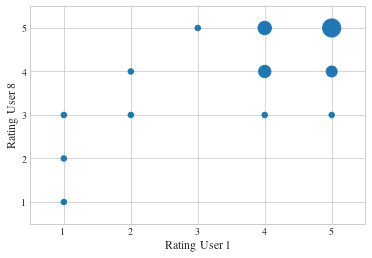

In [8]:
user_id_1, user_id_2 = 1, 8
movies_user1=data[data['user_id'] ==user_id_1 ][['user_id','movie_id','rating']]
movies_user2=data[data['user_id'] ==user_id_2 ][['user_id','movie_id','rating']]
    
# FIND SHARED FILMS
rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')
x= rep.rating_x + np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_x))
y= rep.rating_y +np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_y))
    
a=rep.groupby(['rating_x', 'rating_y']).size()
x=[]
y=[]
s=[]
for item,b in a.iteritems():
    x.append(item[0])
    y.append(item[1])
    s.append(b*30)

fig = plt.figure(figsize=(6,4))
plt.scatter(x,y, s=s)
plt.xlabel('Rating User 1')
plt.ylabel('Rating User '+str(8))
plt.axis([0.5,5.5,0.5,5.5])
plt.savefig("corre18.png",dpi= 300, bbox_inches='tight')
plt.show()

And, with user 31:

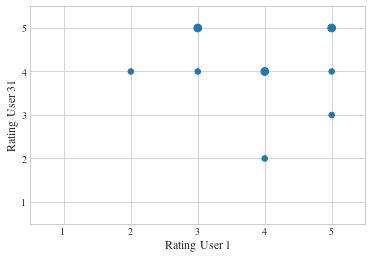

In [9]:
user_id_1, user_id_2 = 1, 31
movies_user1=data[data['user_id'] ==user_id_1 ][['user_id','movie_id','rating']]
movies_user2=data[data['user_id'] ==user_id_2 ][['user_id','movie_id','rating']]
    
# FIND SHARED FILMS
rep=pd.merge(movies_user1 ,movies_user2,on='movie_id')
x= rep.rating_x + np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_x))
y= rep.rating_y +np.random.normal(loc=0.0, scale=0.1,size=len(rep.rating_y))
    
a=rep.groupby(['rating_x', 'rating_y']).size()
x=[]
y=[]
s=[]

fig = plt.figure(figsize=(6,4))
for item,b in a.iteritems():
    x.append(item[0])
    y.append(item[1])
    s.append(b*30)
plt.scatter(x,y, s=s)
plt.xlabel('Rating User 1')
plt.ylabel('Rating User '+str(31))
plt.axis([0.5,5.5,0.5,5.5])
plt.savefig("corre131.png",dpi= 300, bbox_inches='tight')
plt.show()


<h3>Evaluation: performance criterion</h3>
In order to validate the system, we will divide the dataset into two different sets: one called \emph{$X\_train$} containing  $80\%$ of the data from each user; and another called \emph{$X\_test$}, with the remaining $20\%$ of the data from each user. In the following code we create a function

In [10]:
def assign_to_set(df):
    sampled_ids = np.random.choice(
        df.index,
        size=np.int64(np.ceil(df.index.size * 0.2)),
        replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df

def create_train_test(data, key = 'user_id'):
    data['for_testing'] = False
    grouped = data.groupby(key, group_keys=False).apply(assign_to_set)
    # dataframe used to train our model
    data_train = data[grouped.for_testing == False]
    # dataframe used to evaluate our model
    data_test = data[grouped.for_testing == True]
    return data_train, data_test


X_train, X_test =  create_train_test(data)

print("#Training samples = ",X_train.shape[0])
print("#Test samples = ",X_test.shape[0])
print('#Users =', X_train.user_id.nunique())
print('#Movies =',X_train.movie_id.nunique())

#Training samples =  79619
#Test samples =  20381
#Users = 943
#Movies = 1648



Once the data is divided in these sets, we can build a model with the **training set** and evaluate its performance using the **test set**. To validate our methods we can use the standard Root Mean Square Error (RMSE):

In [11]:
def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

Or instead, we can use ranking measures such as Precision, Reacall or Average Precision (AP).

In [12]:
def precision(recommended_items, relevant_items):
    is_relevant = np.in1d(recommended_items, 
                          relevant_items, 
                          assume_unique=True)
    
    precision = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision

def recall(recommended_items, relevant_items):  
    is_relevant = np.in1d(recommended_items, 
                          relevant_items, 
                          assume_unique=True)
    
    recall = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall

def AP(recommended_items, relevant_items):
    is_relevant = np.in1d(recommended_items, 
                          relevant_items, 
                          assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

We define the function **evaluate** which computes the RMSE and the ranking metrics.

In [13]:
def evaluate(rec_object, train, test, 
             at = 20, thr_relevant= 4):
    """ Perfomance evaluation """
    
    # RMSE evaluation
    ids_to_estimate = zip(test.user_id, test.movie_id)
    y_estimated = np.array([rec_object.predict_score(u,i) 
                          if u in train.user_id else 3 
                          for (u,i) in ids_to_estimate ])
    
    y_real = test.rating.values
    rmse = compute_rmse(y_estimated, y_real)
    
    print("RMSE: {:.4f}".format(rmse))
          
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0

    num_eval = 0

    for user_id in tqdm(test.user_id.unique()):

        relevant_items = test[(test.user_id==user_id )&( test.rating>=thr_relevant)].movie_id.values

        if len(relevant_items)>0:

            recommended_items = rec_object.predict_top(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)

    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval

    print("Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 
    

## Recommender System 

### Naïve Recommender System 

First of all, let's build our naive recommender: A random recommender system.

We can define our recommender system with a Python class. This class consists of a constructor and three methods: `fit`, `predict_score` and `predict_top`.

In [14]:
class RandomRecommender():

    def fit(self, train):
        self.items = train.title.unique()
    
    def predict_score(self, user_id, movie_id):
        '''Given a user_id and movie_id predict its score'''
        return np.random.uniform(1,5)
    
    def predict_top(self, user_id, at=5):
        '''Given a user_id predicts its top 'at' movies'''
        recommended_items = np.random.choice(self.items, at)

        return recommended_items

We are ready to create the object and train it using training data. We can do it with the following code:

In [15]:
random_model = RandomRecommender()
random_model.fit(X_train)

Once the model is trained, we can evaluate it as follows:

In [16]:
evaluate(random_model,X_train,X_test)

RMSE: 1.6194


100%|███████████████████████████████████████| 943/943 [00:00<00:00, 1637.41it/s]

Precision = 0.0000, Recall = 0.0000, MAP = 0.0000


The random model has achieved an RMSE of 1.6241 and Precision, Recall and MAP of 0.0\%. These are the numbers we need to beat.

### Collaborative Recommender System 

Similarly, we can build our collaborative recommender system with a Python class. This class consists of a constructor and three methods: `fit`, `predict_score` and `predict_top`. In this case,  the `fit` will be in charge to compute and store the users similarities into a Python dictionary. This is a really simple method but quite expensive in terms of computation when dealing with a large dataset. We decided to show one of the most basic schemes in order to implement it. More complex algorithms can be used in order to improve the computations cost. Moreover, online strategies can be used when dealing with a really dynamic problems. In the \texttt{predict} the score for a movie and a user is estimated.

In [17]:
class CollaborativeFiltering:
    """ Collaborative filtering model """
    
    def __init__(self, similarity = 'pearson'):
        """ Constructor """
        self.sim_method=similarity
        self.sim = {}

    def fit(self, train):
        """ Prepare data structures for estimation. Similarity matrix for users """
        print("Learning...")
        self.train = train
        allUsers = set(self.train['user_id'])
        
        for usr_1 in tqdm(allUsers):
            self.sim.setdefault(usr_1, {})
            a = self.train[self.train.user_id == usr_1][['movie_id']]
            data_reduced = pd.merge(self.train, a , on='movie_id') 
            for usr_2 in allUsers:
                # Avoid our-self
                if usr_1 == usr_2: continue
                self.sim.setdefault(usr_2, {})
                if(usr_1 in self.sim[usr_2]):
                    continue # since is a simetric matrix
                sim = user_sim(data_reduced, usr_1, usr_2, 
                               method = self.sim_method)
                if(sim < 0):
                    self.sim[usr_1][usr_2]=0
                    self.sim[usr_2][usr_1]=0
                else:
                    self.sim[usr_1][usr_2]=sim
                    self.sim[usr_2][usr_1]=sim
                
    def predict_score(self, usr_id, movie_id):
        ''' Given a user_id and movie_id it predicts its score'''
        seen = self.train[self.train.movie_id == movie_id]
        rating_num, rating_den = 0.0, 0.0
        allUsers = set(seen['user_id'])
        for other in allUsers:
            if usr_id == other: continue 
            rating_num += self.sim[usr_id][other] * float(seen[seen['user_id']==other]['rating'])
            rating_den += self.sim[usr_id][other]
        if rating_den == 0: 
            if self.train.rating[self.train['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.train.rating[self.train['movie_id']==movie_id].mean()
            else:# return mean user rating 
                return self.train.rating[self.train['user_id']==usr_id].mean()
        return rating_num/rating_den

    def predict_top(self, usr_id, at=5, remove_seen=True):
        '''Given a usr_id predict its top 'at' movies'''
        seen_items = self.train[self.train.user_id==usr_id].movie_id.values
        unseen_items = set(self.train.movie_id.values) - set(seen_items)

        predictions = [(item_id,self.predict_score(usr_id,item_id)) for item_id in unseen_items]

        sorted_predictions = sorted(predictions, key=lambda x: x[1],reverse = True)[:at]
        return [i[0] for i in sorted_predictions]

In [18]:
class CollaborativeFiltering:
    """ Collaborative filtering model """
    
    def __init__(self, similarity = 'pearson'):
        '''Constructor'''
        self.sim_method=similarity
        self.sim = {}

    def fit(self, train):
        '''Prepare data structures for estimation'''
        self.train = train
        allUsers = set(self.train['user_id'])
        
        # Create a dictionary with user, movie, rating
        self.seen_movies = {user: {} for user in allUsers}
        
        for user in allUsers:
            user_ratings = train[train.user_id == user][['movie_id', 'rating']]
            self.seen_movies[user] = dict(zip(user_ratings['movie_id'], user_ratings['rating']))
    
        for usr_1 in tqdm(allUsers):
            self.sim.setdefault(usr_1, {})
            a = self.train[self.train.user_id == usr_1][['movie_id']]
            data_reduced = pd.merge(self.train, a , on='movie_id') 
            
            for usr_2 in allUsers:
                # Avoid comparing a user with themselves
                if usr_1 == usr_2: 
                    continue      
                self.sim.setdefault(usr_2, {})
                if(usr_1 in self.sim[usr_2]):
                    continue # since is a simetric matrix
                sim = user_sim(data_reduced, usr_1, usr_2, 
                               method = self.sim_method)
                if(sim < 0):
                    self.sim[usr_1][usr_2]=0
                    self.sim[usr_2][usr_1]=0
                else:
                    self.sim[usr_1][usr_2]=sim
                    self.sim[usr_2][usr_1]=sim
        
        
    def predict_score(self, usr_id, movie_id):
        ''' Given a user_id and movie_id it predicts its score'''
        seen = self.train[self.train.movie_id == movie_id]
        rating_num, rating_den = 0.0, 0.0
        allUsers = set(seen['user_id'])
        # Iterate through all users who have seen the movie
        for other in allUsers:
            if usr_id == other:
                continue  # Skip the current user, as self-similarity is not needed
            
            similarity = self.sim[usr_id][other]
            rating = float(self.seen_movies[other][movie_id])
            
            rating_num += similarity * rating
            rating_den += similarity
            
        # If the denominator is zero (no similar users), handle the case
        if rating_den == 0: 
            if self.train.rating[self.train['movie_id'] == movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.train.rating[self.train['movie_id'] == movie_id].mean()
            else:# return mean user rating 
                return self.train.rating[self.train['user_id'] == usr_id].mean()
       
        # return the predicted score
        return rating_num/rating_den

    def predict_top(self, usr_id, at=20, remove_seen=True):
        '''Given a usr_id predict its top 'at' movies'''
        # Get the movies already seen by the user
        seen_items = set(self.train[self.train.user_id == usr_id].movie_id.values)

        # Get the set of unseen items
        unseen_items = set(self.train.movie_id.values) - seen_items

        # Generate predictions for unseen items
        predictions = [(item_id, self.predict_score(usr_id, item_id)) for item_id in unseen_items]

        # Sort predictions by score in descending order and select the top 'at' items
        sorted_predictions = sorted(predictions, key=lambda x: x[1], reverse=True)[:at]

        # Extract the item IDs from the sorted predictions
        top_items = [item_id for item_id, _ in sorted_predictions]
        
        return top_items

In [19]:
cf_model = CollaborativeFiltering()
cf_model.fit(X_train)
cf_model.predict_score(usr_id = 2, movie_id = 1)

  0%|                                                   | 0/943 [00:00<?, ?it/s]/Users/santisegui/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|█████████████████████████████████████████| 943/943 [13:58<00:00,  1.12it/s]


3.9172564848588474

In [20]:
# It can take a lot of time..
evaluate(cf_model,X_train,X_test, at = 50)

RMSE: 1.0655


100%|█████████████████████████████████████████| 943/943 [08:19<00:00,  1.89it/s]

Precision = 0.0175, Recall = 0.0598, MAP = 0.0029


<div class  = "alert alert-success">**EXERCISE 1**<p>
Modify the Recomender System using as a prediction function the following equation:
$$pred(a,p) = \bar{r_a} + \frac{\sum_{b \in N}{sim(a,b)*(r_{b,p}-\bar{r_b})}}{\sum_{b \in N}{sim(a,b)}}$$

</div>

In [21]:
class CollaborativeFiltering_Ex1(CollaborativeFiltering):
    def predict_score(self, usr_id, movie_id, N = 10):
        ''' Given a user_id and movie_id it predicts its score'''
        seen = self.train[self.train['movie_id'] ==movie_id]
        rating_num, rating_den = 0.0, 0.0
        allUsers = set(seen['user_id'])
        
        #top_users = sorted([(self.sim[user_id][other],other) 
        #                    for other in movie_users.user_id.values i
        #                    f other in self.sim[user_id]])[::-1]
        for other in allUsers:
            if usr_id == other:
                continue  # Skip the current user, as self-similarity is not needed
            similarity = self.sim[usr_id][other]
            rating = float(self.seen_movies[other][movie_id])
            mean_user_rating = np.mean([self.seen_movies[other][key] 
                                        for key in self.seen_movies[other]])
            rating_num += similarity * float(rating - mean_user_rating)  
            rating_den += similarity
        if rating_den == 0: 
            if self.train.rating[self.train['movie_id'] == movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.train.rating[self.train['movie_id'] == movie_id].mean()
            else:
                # else return mean user rating 
                return self.train.rating[self.train['user_id'] == usr_id].mean()
        mean_rating_user = self.train[self.train.user_id==usr_id].rating.mean()
        return mean_rating_user + rating_num/rating_den

In [22]:
cf_model_v2 = CollaborativeFiltering_Ex1()
cf_model_v2.fit(X_train)
cf_model_v2.predict_score(usr_id = 2, movie_id = 1)

100%|█████████████████████████████████████████| 943/943 [14:08<00:00,  1.11it/s]


4.143262847804112

In [23]:
evaluate(cf_model_v2, X_train, X_test, at = 50)

RMSE: 1.0151


100%|█████████████████████████████████████████| 943/943 [46:41<00:00,  2.97s/it]

Precision = 0.0089, Recall = 0.0305, MAP = 0.0015


<div class="alert alert-success">
**EXERCISE 2:**<br>
Modify the recomender system from the previous exercice, with one that in order to estimate the score of a movie B for the user A only uses the subset of the N most similar users to user A. Define N as a parameter of the Recoomender.
</div>

In [28]:
class CollaborativeFiltering_Ex2(CollaborativeFiltering):
    def predict_score(self, usr_id, movie_id, N = 10):
        seen = self.train[self.train['movie_id'] ==movie_id]
        rating_num, rating_den = 0.0, 0.0
        allUsers = set(seen['user_id'])
        
        # SELECT TOP USERS
        top_users = sorted([(self.sim[usr_id][other],other) 
                            for other in seen.user_id.values 
                            if other in self.sim[usr_id]])[::-1]
        
        for sim, other in top_users[:N]:
            if user_id == other: continue 
                
            similarity = self.sim[usr_id][other]
            rating = float(self.seen_movies[other][movie_id])
            mean_user_rating = np.mean([self.seen_movies[other][key] 
                                        for key in self.seen_movies[other]])
            
            rating_num += similarity * float(rating - mean_user_rating)  
            rating_den += similarity
        if rating_den == 0: 
            if self.train.rating[self.train['movie_id']==movie_id].mean()>0:
                # return the mean movie rating if there is no similar for the computation
                return self.train.rating[self.train['movie_id']==movie_id].mean()
            else:
                # else return mean user rating 
                return self.train.rating[self.train['user_id'] == usr_id].mean()
        mean_rating_user = self.train[self.train.user_id == usr_id].rating.mean()
        return mean_rating_user + rating_num/rating_den

In [ ]:
cf_model_v3 = CollaborativeFiltering_Ex2()
cf_model_v3.fit(X_train)
cf_model_v3.predict_score(usr_id = 2, movie_id = 1)

  0%|▏                                          | 4/943 [00:07<28:39,  1.83s/it]

In [ ]:
evaluate(cf_model_v2, X_train, X_test, at = 50)

<div class  = "alert alert-success">**EXERCISE 4**<p>
Modify the similarity function with the following:
$$new\_sim(a,b) = sim(a,b) * \frac{min(50,|P_{ab}|)}{50} $$
where $|P_{ab}|$ is the number of common items with user $a$ and user $b$
</div>

In [ ]:
def user_sim(df, user_1, user_2, 
             min_common_items = 1, 
             method = 'pearson',
             min_common = 20):
    # GET MOVIES OF USER1
    mov_usr1 = df[df['user_id'] == user_1 ]
    # GET MOVIES OF USER2
    mov_usr2 = df[df['user_id'] == user_2 ]
    
    # FIND SHARED FILMS
    df_shared = pd.merge(mov_usr1, mov_usr2, on='movie_id')  
    n_common = df_shared.shape[0]
    
    # If there is no enough common items to compute similarity
    if(n_common<=min_common_items):
        return 0
    
    penalty = min(min_common,n_common)/min_common
    if method =='pearson':
        res=pearsonr(df_shared['rating_x'],df_shared['rating_y'])[0]
        if(np.isnan(res)):
            return 0
        return res * penalty
    
    elif method =='euclidean':
        res = 1.0/(1.0+euclidean(df_shared['rating_x'],
                                  df_shared['rating_y'])) 
        return res * penalty
    else:
        print("method not defined")
        return 0

In [ ]:
cf_model_v4 = CollaborativeFilteringEx3()
cf_model_v4.learn(X_train)
cf_model_v4.estimate(usr_id = 2, movie_id = 1)

In [ ]:
evaluate(cf_model_v4,X_train,X_test)